In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls "/content/drive/MyDrive/yolo_ass3"

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


In [4]:
!pip install ultralytics torch torchvision opencv-python matplotlib

In [ ]:
!pip install ultralytics

In [5]:
from ultralytics import YOLO

In [6]:
import torch
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os
import glob
from PIL import Image
import numpy as np

In [7]:
DATASET_PATH = "/content/drive/MyDrive/yolo_ass3"  # Change to your dataset path
IMG_SIZE = 416  # Image size for training

import torch
import torch.nn as nn
from torchvision.models.vision_transformer import vit_b_16  # Example Vision Transformer

# Load YOLOv10m model
model = YOLO("yolov10m.pt")




In [8]:
import torch
import torch.nn as nn
from torchvision.models.vision_transformer import vit_b_16  # Small Vision Transformer

class HybridBackbone(nn.Module):
    def __init__(self, yolo_backbone, transformer):
        super().__init__()
        self.yolo_backbone = yolo_backbone
        self.transformer = transformer

    def forward(self, x):
        # Extract features using YOLO's CNN backbone
        cnn_features = self.yolo_backbone(x)

        # Transformer expects a different input shape, so adjust it
        b, c, h, w = cnn_features.shape
        cnn_features = cnn_features.view(b, c, -1).permute(2, 0, 1)  # Reshape for transformer input

        # Extract transformer features
        transformer_features = self.transformer(cnn_features)

        # Reshape back to CNN format
        transformer_features = transformer_features.permute(1, 2, 0).view(b, c, h, w)

        return transformer_features

# Extract YOLO's original backbone
yolo_backbone = model.model.model[0]  # This extracts YOLO's backbone

# Load a pretrained Vision Transformer
transformer = vit_b_16(pretrained=True)
transformer.heads = nn.Identity()  # Remove classification head

# Create a new hybrid backbone
hybrid_backbone = HybridBackbone(yolo_backbone, transformer)

# Replace YOLO's backbone with the hybrid version
model.model.model[0] = hybrid_backbone


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
model.train(
    epochs=50,
    batch=16,
    imgsz=416,
    device="cuda" if torch.cuda.is_available() else "cpu",
    patience=6,  # Early stopping with patience 6

    data="/content/drive/MyDrive/yolo_ass3/data.yaml",
)

Ultralytics 8.3.98 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov10m.pt, data=/content/drive/MyDrive/yolo_ass3/data.yaml, epochs=50, time=None, patience=6, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=

train: Scanning /content/drive/My Drive/yolo_ass3/train/labels... 2436 images, 420 backgrounds, 0 corrupt: 100%|██████████| 2436/2436 [12:44<00:00,  3.19it/s]


train: New cache created: /content/drive/My Drive/yolo_ass3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/My Drive/yolo_ass3/valid/labels... 266 images, 42 backgrounds, 0 corrupt: 100%|██████████| 266/266 [01:17<00:00,  3.45it/s]

val: New cache created: /content/drive/My Drive/yolo_ass3/valid/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 129 weight(decay=0.0), 142 weight(decay=0.0005), 141 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.84G      3.931      8.736      3.884         19        416: 100%|██████████| 153/153 [00:56<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.42it/s]

                   all        266        295     0.0358      0.108     0.0181    0.00814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.43G      4.256      7.152       4.04          6        416: 100%|██████████| 153/153 [00:52<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]


                   all        266        295      0.287     0.0623      0.017    0.00523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.48G      4.185      7.111      3.986          2        416: 100%|██████████| 153/153 [00:51<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]

                   all        266        295      0.378     0.0374     0.0374     0.0112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.58G      4.062      6.818       3.85          9        416: 100%|██████████| 153/153 [00:51<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.40it/s]


                   all        266        295      0.338      0.136     0.0606     0.0233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.66G      3.971      6.639      3.748          4        416: 100%|██████████| 153/153 [00:50<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.91it/s]

                   all        266        295      0.394      0.127      0.086     0.0366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.74G      3.871      6.398      3.649          5        416: 100%|██████████| 153/153 [00:50<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.79it/s]

                   all        266        295       0.18      0.145      0.106     0.0452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.79G      3.795      6.165      3.638          8        416: 100%|██████████| 153/153 [00:50<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

                   all        266        295      0.164      0.183       0.13     0.0534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       4.9G      3.709       5.97      3.586          7        416: 100%|██████████| 153/153 [00:50<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

                   all        266        295      0.186      0.173      0.171     0.0646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.98G      3.722      5.909      3.577          5        416: 100%|██████████| 153/153 [00:50<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.71it/s]


                   all        266        295      0.231      0.208      0.185     0.0816

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.05G      3.649      5.808      3.506          9        416: 100%|██████████| 153/153 [00:51<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.28it/s]

                   all        266        295      0.245      0.222      0.181     0.0873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.11G      3.558      5.632      3.487          8        416: 100%|██████████| 153/153 [00:51<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]

                   all        266        295      0.256      0.271      0.221      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.21G      3.548      5.686      3.468          7        416: 100%|██████████| 153/153 [00:51<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.22it/s]

                   all        266        295      0.289      0.232      0.212      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.29G      3.558      5.503      3.459         10        416: 100%|██████████| 153/153 [00:51<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.45it/s]

                   all        266        295       0.25      0.248      0.217      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.37G      3.496      5.385      3.429          8        416: 100%|██████████| 153/153 [00:51<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.54it/s]


                   all        266        295      0.275      0.243      0.241      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.42G      3.424      5.333      3.394          8        416: 100%|██████████| 153/153 [00:51<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.40it/s]


                   all        266        295      0.271      0.275      0.215      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.53G      3.497      5.234      3.396          9        416: 100%|██████████| 153/153 [00:51<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.53it/s]

                   all        266        295      0.261      0.273      0.244      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.61G      3.374      5.213      3.364          8        416: 100%|██████████| 153/153 [00:51<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.63it/s]

                   all        266        295      0.242      0.277      0.212      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.68G      3.381      5.219      3.347         17        416: 100%|██████████| 153/153 [00:51<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.57it/s]

                   all        266        295      0.376      0.322      0.312      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.74G      3.399      5.126      3.353          6        416: 100%|██████████| 153/153 [00:52<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.59it/s]

                   all        266        295      0.356        0.3      0.281      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.84G      3.339      5.042      3.356          7        416: 100%|██████████| 153/153 [00:51<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.57it/s]

                   all        266        295      0.263      0.337      0.276      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.92G      3.311      4.978      3.303          4        416: 100%|██████████| 153/153 [00:51<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.51it/s]

                   all        266        295      0.329      0.301      0.282      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         6G      3.305      4.904      3.304          3        416: 100%|██████████| 153/153 [00:51<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.53it/s]

                   all        266        295      0.316      0.341      0.302      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.05G      3.294      4.906      3.288          6        416: 100%|██████████| 153/153 [00:51<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.45it/s]

                   all        266        295      0.307      0.314      0.298      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.15G      3.239      4.835      3.293          3        416: 100%|██████████| 153/153 [00:51<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.57it/s]

                   all        266        295      0.308       0.35      0.297      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.45G      3.236      4.748      3.295          8        416: 100%|██████████| 153/153 [00:51<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]

                   all        266        295      0.378      0.352      0.315       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.53G       3.19      4.684      3.236          7        416: 100%|██████████| 153/153 [00:52<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.54it/s]


                   all        266        295      0.373      0.372      0.351      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.58G       3.13      4.614       3.23          9        416: 100%|██████████| 153/153 [00:51<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.46it/s]

                   all        266        295      0.318      0.394       0.34      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.69G      3.143      4.525      3.184          7        416: 100%|██████████| 153/153 [00:51<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]

                   all        266        295      0.354      0.398      0.371      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.76G       3.14      4.447      3.176          8        416: 100%|██████████| 153/153 [00:51<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.54it/s]

                   all        266        295      0.405      0.406       0.37      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.84G      3.134      4.471       3.18         12        416: 100%|██████████| 153/153 [00:52<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.56it/s]

                   all        266        295      0.432      0.405      0.383      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       6.9G      3.118      4.428      3.166          6        416: 100%|██████████| 153/153 [00:51<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.46it/s]


                   all        266        295      0.399      0.421      0.359      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         7G      3.096      4.257      3.172         17        416: 100%|██████████| 153/153 [00:51<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.35it/s]

                   all        266        295       0.44      0.387      0.395      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.08G      3.043      4.332      3.138          9        416: 100%|██████████| 153/153 [00:51<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.18it/s]

                   all        266        295      0.425      0.398      0.381      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.16G      3.035      4.219       3.13         15        416: 100%|██████████| 153/153 [00:51<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]

                   all        266        295      0.431      0.418      0.405       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.21G      3.011      4.172      3.118          5        416: 100%|██████████| 153/153 [00:51<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]

                   all        266        295      0.453      0.437      0.411      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.31G      2.994      4.132      3.123         12        416: 100%|██████████| 153/153 [00:50<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.53it/s]


                   all        266        295      0.455      0.412      0.414      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.39G      3.025      4.003      3.128          6        416: 100%|██████████| 153/153 [00:50<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.55it/s]

                   all        266        295      0.512      0.382      0.421      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.47G      2.954      3.985      3.093          4        416: 100%|██████████| 153/153 [00:52<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.19it/s]

                   all        266        295      0.502      0.447      0.452      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.53G      2.925      3.891      3.063          7        416: 100%|██████████| 153/153 [00:51<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.54it/s]

                   all        266        295      0.493      0.454      0.468       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.63G      2.878      3.916      3.025          6        416: 100%|██████████| 153/153 [00:51<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.44it/s]


                   all        266        295      0.476       0.45      0.423      0.233
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.71G      2.891      3.507       3.11          4        416: 100%|██████████| 153/153 [00:52<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.45it/s]


                   all        266        295      0.526      0.473      0.469      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.79G      2.846      3.388      3.098          3        416: 100%|██████████| 153/153 [00:51<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.35it/s]


                   all        266        295      0.495      0.488      0.469      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.84G      2.822      3.236      3.067          6        416: 100%|██████████| 153/153 [00:51<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.53it/s]

                   all        266        295      0.579      0.443      0.483      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.94G      2.755      3.143      3.031          6        416: 100%|██████████| 153/153 [00:51<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.59it/s]


                   all        266        295      0.444      0.496      0.466      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.03G      2.741      3.058      3.013         10        416: 100%|██████████| 153/153 [00:51<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.40it/s]

                   all        266        295        0.6      0.463      0.511      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       8.1G      2.726      3.001      2.984          5        416: 100%|██████████| 153/153 [00:51<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.50it/s]

                   all        266        295       0.55      0.489      0.503       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.15G      2.676      2.939      2.985          9        416: 100%|██████████| 153/153 [00:51<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]

                   all        266        295      0.506      0.482      0.495      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      8.26G      2.652      2.941      2.941          6        416: 100%|██████████| 153/153 [00:51<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.55it/s]

                   all        266        295      0.543      0.561      0.531      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.34G      2.583      2.824      2.906          4        416: 100%|██████████| 153/153 [00:51<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.53it/s]

                   all        266        295      0.536      0.558       0.54      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      8.43G      2.598      2.789      2.907          5        416: 100%|██████████| 153/153 [00:51<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.49it/s]

                   all        266        295      0.547      0.559      0.532      0.288



50 epochs completed in 0.778 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 33.4MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 33.4MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.98 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10m summary (fused): 159 layers, 16,455,016 parameters, 0 gradients, 63.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]


                   all        266        295      0.537      0.558       0.54      0.288
                 cloth         49         68      0.587      0.603      0.532       0.31
                 glass         60         60      0.735        0.7      0.755       0.38
                 metal         45         55      0.408      0.473      0.405      0.201
               plastic         80        112      0.417      0.455      0.468      0.261
Speed: 0.3ms preprocess, 5.0ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dad920c7750>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [10]:
metrics = model.val()  # Validate the model

# Extract values correctly
precision = metrics.box.p.mean()  # Mean Precision
recall = metrics.box.r.mean()  # Mean Recall
map50 = metrics.box.map50  # Mean Average Precision @ 50
map50_95 = metrics.box.map  # Mean Average Precision @ 50-95

# Print metrics
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, mAP@50: {map50:.4f}, mAP@50-95: {map50_95:.4f}")

Ultralytics 8.3.98 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10m summary (fused): 159 layers, 16,455,016 parameters, 0 gradients, 63.4 GFLOPs


val: Scanning /content/drive/My Drive/yolo_ass3/valid/labels.cache... 266 images, 42 backgrounds, 0 corrupt: 100%|██████████| 266/266 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:04<00:00,  3.45it/s]


                   all        266        295      0.537      0.558       0.54      0.289
                 cloth         49         68       0.59      0.603      0.532       0.31
                 glass         60         60      0.736        0.7      0.758      0.385
                 metal         45         55      0.406      0.472      0.401      0.199
               plastic         80        112      0.415      0.456      0.469      0.261
Speed: 1.0ms preprocess, 10.1ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/train22
Precision: 0.5369, Recall: 0.5577, mAP@50: 0.5399, mAP@50-95: 0.2887



0: 416x416 1 glass, 20.8ms
Speed: 2.1ms preprocess, 20.8ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)


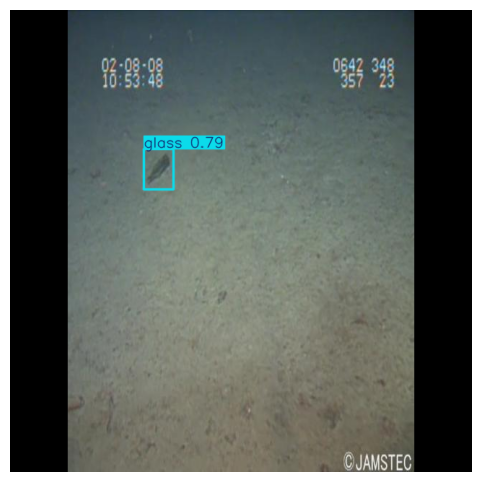

In [11]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import glob

def visualize_results(img_path, model):
    img = Image.open(img_path)
    results = model(img)

    # Extract the first result and get the plotted image
    result_img = results[0].plot()

    # Convert image to NumPy array if it's not already
    result_img = np.array(result_img)

    # Convert BGR (OpenCV default) to RGB for correct display in matplotlib
    result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

    # Show image with bounding boxes
    plt.figure(figsize=(6,6))
    plt.imshow(result_img)
    plt.axis("off")
    plt.show()
    plt.pause(0.001)  # Force display update
    plt.close()  # Prevent duplicate figures

# Load test images
test_images = glob.glob("/content/drive/MyDrive/yolo_ass3/test/images/*.jpg")

# Run visualization
if test_images:
    visualize_results(test_images[200], model)
else:
    print("No test images found.")

In [12]:
import glob
model_files = glob.glob("/content/runs/detect/*/weights/best.pt")
print("Available model files:", model_files)

Available model files: ['/content/runs/detect/train2/weights/best.pt']


In [13]:
import glob

# List all training runs
train_folders = glob.glob("/content/runs/detect/*/")

print("Available training runs:")
for folder in train_folders:
    print(folder)

Available training runs:
/content/runs/detect/train/
/content/runs/detect/train2/
/content/runs/detect/train22/


In [14]:
import glob

# Check logs inside different training folders
for folder in train_folders:
    log_files = glob.glob(folder + "/*.csv")
    if log_files:
        print(f"✅ Logs found in: {folder}")
        print(log_files)
    else:
        print(f"❌ No CSV logs found in: {folder}")

❌ No CSV logs found in: /content/runs/detect/train/
✅ Logs found in: /content/runs/detect/train2/
['/content/runs/detect/train2/results.csv']
❌ No CSV logs found in: /content/runs/detect/train22/


Available columns: Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


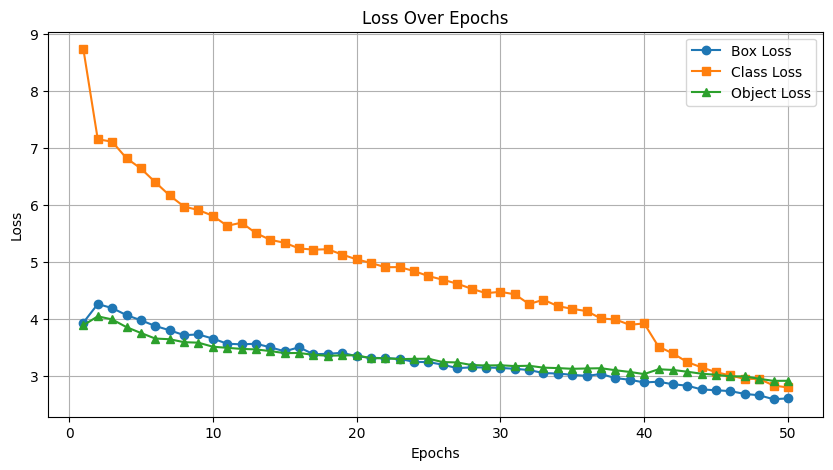

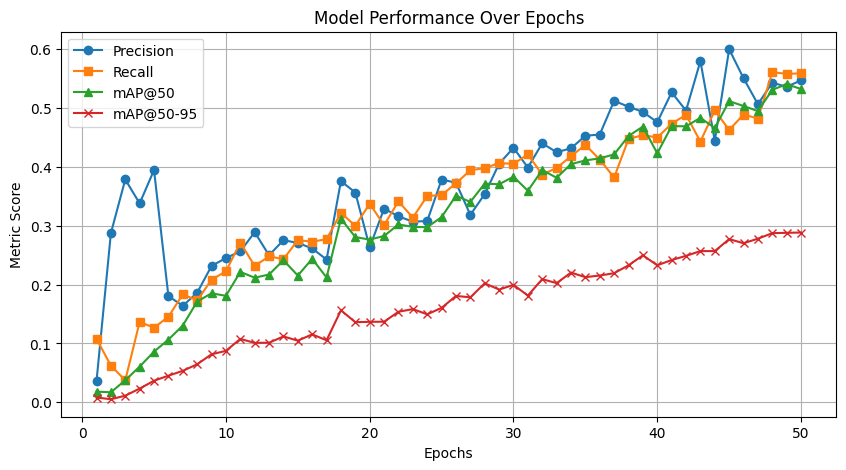

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

# Load the CSV file
csv_path = "/content/runs/detect/train2/results.csv"
df = pd.read_csv(csv_path)

# Print column names to check available metrics
print("Available columns:", df.columns)

# ✅ Force Matplotlib to display the figures
def plot_loss():
    plt.figure(figsize=(10, 5))
    plt.plot(df["epoch"], df["train/box_loss"], label="Box Loss", marker='o')
    plt.plot(df["epoch"], df["train/cls_loss"], label="Class Loss", marker='s')
    plt.plot(df["epoch"], df["train/dfl_loss"], label="Object Loss", marker='^')

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()
    plt.grid()
    plt.show(block=True)  # ✅ Forces Jupyter to display

def plot_accuracy():
    plt.figure(figsize=(10, 5))
    plt.plot(df["epoch"], df["metrics/precision(B)"], label="Precision", marker='o')
    plt.plot(df["epoch"], df["metrics/recall(B)"], label="Recall", marker='s')
    plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@50", marker='^')
    plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP@50-95", marker='x')

    plt.xlabel("Epochs")
    plt.ylabel("Metric Score")
    plt.title("Model Performance Over Epochs")
    plt.legend()
    plt.grid()
    plt.show(block=True)  # ✅ Forces Jupyter to display

# ✅ Call the functions
plot_loss()
plot_accuracy()


In [23]:
from ultralytics import YOLO

# Load the trained YOLO model
model = YOLO("/content/runs/detect/train2/weights/best.pt")

# Evaluate on the test dataset
metrics = model.val(data="/content/drive/MyDrive/yolo_ass3/data.yaml", split="test")

# Extract performance metrics
print("mAP50:", metrics.box.map50)      # Mean Average Precision at IoU 0.5
print("mAP50-95:", metrics.box.map)     # Mean Average Precision at IoU 0.5:0.95
print("Precision:", metrics.box.p.mean())   # Mean Precision across all classes
print("Recall:", metrics.box.r.mean())  # Mean Recall across all classes
print("F1 Score:", metrics.box.f1.mean())  # Mean F1 Score

Ultralytics 8.3.98 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10m summary (fused): 159 layers, 16,455,016 parameters, 0 gradients, 63.4 GFLOPs


val: Scanning /content/drive/My Drive/yolo_ass3/test/labels... 266 images, 46 backgrounds, 0 corrupt: 100%|██████████| 266/266 [01:24<00:00,  3.15it/s]

val: New cache created: /content/drive/My Drive/yolo_ass3/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


                   all        266        321      0.525      0.548      0.528      0.267
                 cloth         46         70      0.447      0.486      0.462      0.272
                 glass         59         59      0.717       0.78      0.804      0.386
                 metal         45         56      0.459      0.446       0.39       0.18
               plastic         82        136      0.479       0.48      0.457      0.232
Speed: 1.4ms preprocess, 10.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val2
mAP50: 0.5283371154271125
mAP50-95: 0.2672029442529099
Precision: 0.5252979711918598
Recall: 0.5479614919502597
F1 Score: 0.5360757862781227


In [26]:
import shutil

# Define source and destination paths
source_path = "/content/runs/detect/train2/weights/best.pt"
destination_path = "/content/yolov10m.pt"

# Ensure the destination folder exists
shutil.os.makedirs("/content/drive/My Drive/saved_models", exist_ok=True)

# Copy the trained model to Google Drive
shutil.copy(source_path, destination_path)

print(f"✅ Model successfully saved to: {destination_path}")

✅ Model successfully saved to: /content/yolov10m.pt
